In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Priority Thread Scheduling

In [3]:
def plot_load_cdfs_sched(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data[data['context'] == 0], 'resp_time', label='{}-C0'.format(m))
        df_plot_cdf(data[data['context'] == 1], 'resp_time', label='{}-C1'.format(m))
        print('Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data)))

In [4]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_sched(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        for c in [0, 1]:
            # extract all data for this context at this load
            req_context_df = req_load_df[req_load_df['context'] == c]
            resp_context_df = resp_load_df[resp_load_df['context'] == c]
            # add dummy rows with infinite resp time if needed
            if len(resp_context_df) < len(req_context_df):
                dummy_row = resp_context_df.head(1).copy()
                dummy_row['resp_time'] = 1e100
                dummy_rows = pd.concat([dummy_row]*(len(req_context_df) - len(resp_context_df)), ignore_index=True)
                resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
            elif len(resp_context_df) > len(req_context_df):
                print("WARNING: more responses ({}) received than requests sent ({})! m={}, c={}".format(len(resp_context_df), len(req_context_df), m, c))
    return resp_df

In [5]:
# The target load is different from the actual load.
# So we need to compute the actual load by looking at the request data.
def get_load_map(req_df):
    # create a dict that maps {mean_arrival_time ==> load}
    load_map = {}
    for m in req_df['mean_arrival_time'].unique():
        load_data = req_df[req_df['mean_arrival_time'] == m]
        mean_arrival_time = load_data['sent_time'].diff().mean()
        load_map[m] = 1e3/(mean_arrival_time/3.2) # MRPS
    return load_map

In [6]:
def process_resp_time_sched(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_sched(resp_df, req_df)
    c0_tail = resp_df[resp_df['context'] == 0].groupby('load')['resp_time'].quantile(0.99)
    c1_tail = resp_df[resp_df['context'] == 1].groupby('load')['resp_time'].quantile(0.99)
    c0_median = resp_df[resp_df['context'] == 0].groupby('load')['resp_time'].quantile(0.50)
    c1_median = resp_df[resp_df['context'] == 1].groupby('load')['resp_time'].quantile(0.50)
    return c0_tail, c1_tail, c0_median, c1_median

In [39]:
# resdir = 'results-workload/2021-03-25--18-36-37-lnic-evaluation/switch0'
resdir = 'nanoPU-results/lnic_scheduling/switch0'
lnic_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
lnic_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
lnic_sched_tail_c0, lnic_sched_tail_c1, lnic_sched_median_c0, lnic_sched_median_c1 = process_resp_time_sched(lnic_sched_stats, lnic_sched_req_stats)

In [10]:
# resdir = 'nanoPU-results/scheduling/timer-driven/load-sweep'
resdir = 'results-workload/2021-03-25--18-46-29-lnic-evaluation/switch0'
timer_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
timer_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
timer_sched_tail_c0, timer_sched_tail_c1, timer_sched_median_c0, timer_sched_median_c1 = process_resp_time_sched(timer_sched_stats, timer_sched_req_stats)

<IPython.core.display.Javascript object>


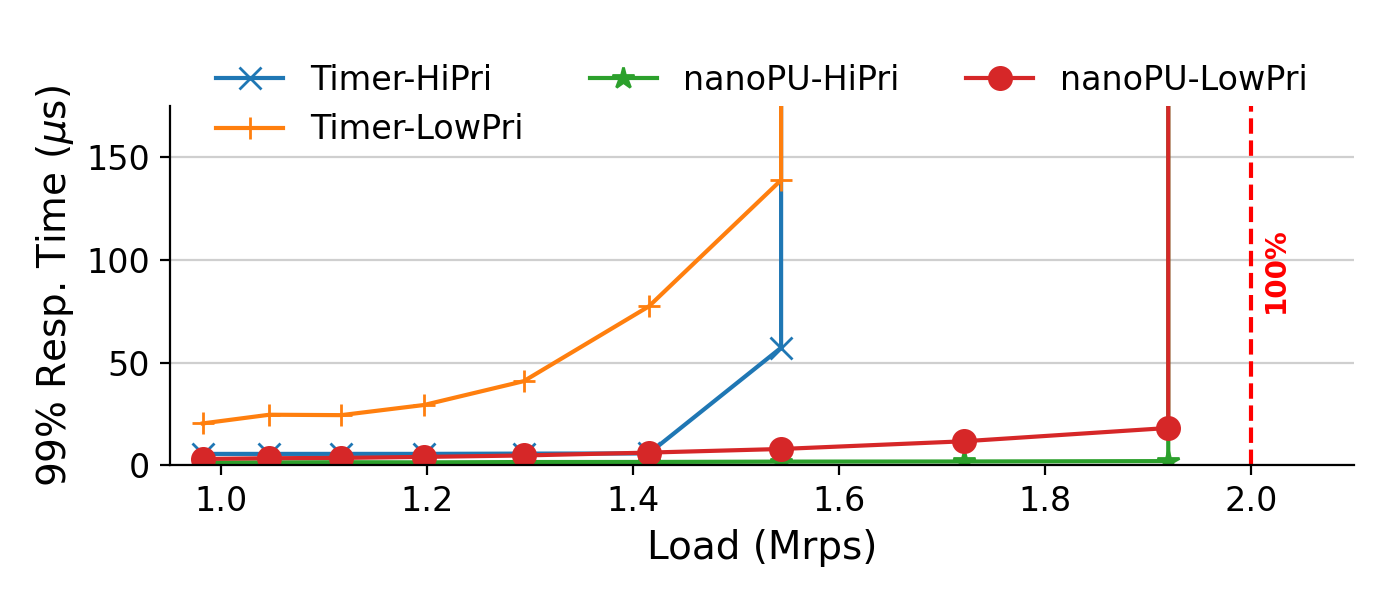

In [40]:
# Plot tail latency vs load
plt.figure(figsize=(7, 3))
ax = plt.gca()
timer_sched_tail_c0.plot(ax=ax, marker='x', markersize=8, label='Timer-HiPri')
timer_sched_tail_c1.plot(ax=ax, marker='+', markersize=8, label='Timer-LowPri')
lnic_sched_tail_c0.plot(ax=ax, marker='*', markersize=8, label='nanoPU-HiPri')
lnic_sched_tail_c1.plot(ax=ax, marker='o', markersize=8, label='nanoPU-LowPri')
ax.axvline(2, linestyle='--', color='r')
ax.text(2.01, 95, '100%', color='r', rotation=90, va='center', weight="bold")
# plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (Mrps)')
plt.ylabel('99% Resp. Time ($\mu$s)')
ax.legend(loc='upper center', frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(alpha=0.6)
plt.ylim([0, 175])
plt.xlim([0.95, 2.1])
plt.tight_layout()
plt.show()

# Bounded Processing Time

In [19]:
# resdir = 'nanoPU-results/scheduling/bounded/load-sweep'
# resdir = 'results-workload/2021-03-25--18-56-50-lnic-evaluation/switch0'
resdir = 'results-workload/2021-03-26--04-53-12-lnic-evaluation/switch0'
bounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
bounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
bounded_tail_c0, bounded_tail_c1, bounded_median_c0, bounded_median_c1 = process_resp_time_sched(bounded_stats, bounded_req_stats)

In [20]:
# resdir = 'nanoPU-results/scheduling/unbounded/load-sweep'
resdir = 'results-workload/2021-03-25--19-02-36-lnic-evaluation/switch0'
unbounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
unbounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
unbounded_tail_c0, unbounded_tail_c1, unbounded_median_c0, unbounded_median_c1 = process_resp_time_sched(unbounded_stats, unbounded_req_stats)

<IPython.core.display.Javascript object>


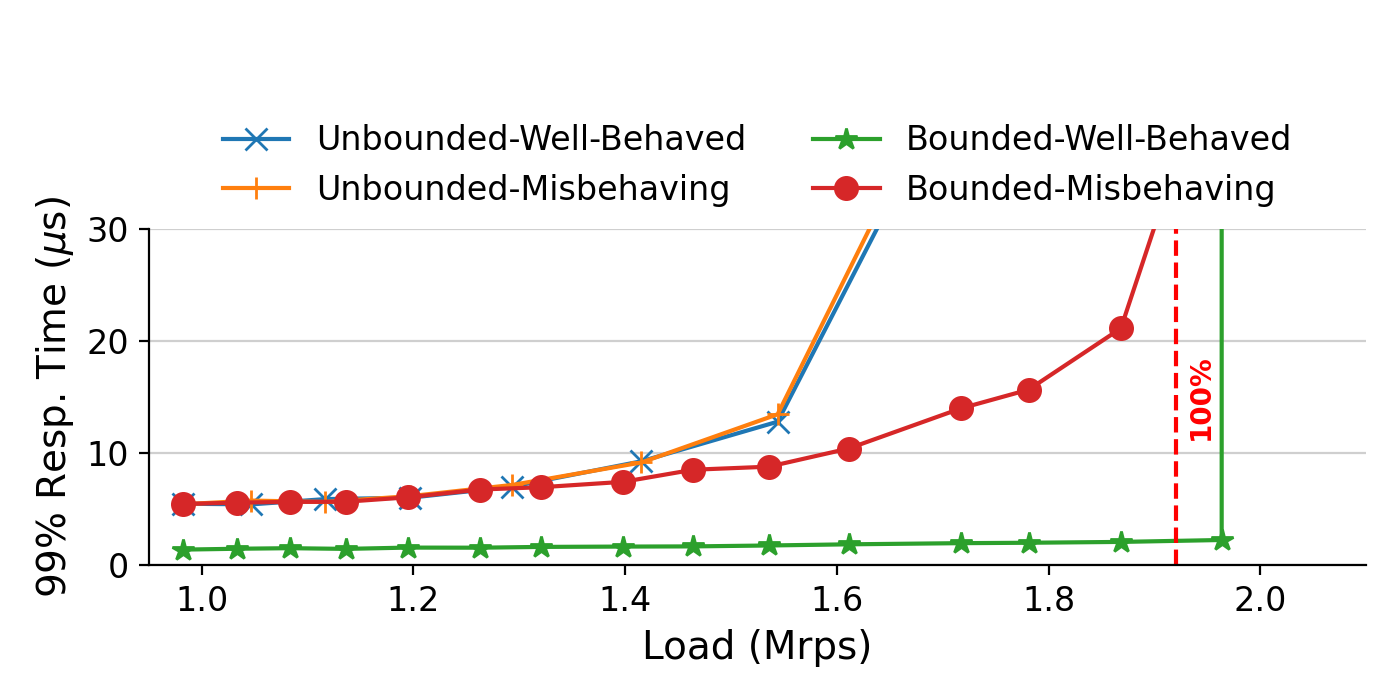

In [38]:
# Plot tail latency vs load
plt.figure(figsize=(7, 3.5))
ax = plt.gca()
unbounded_tail_c0.plot(ax=ax, marker='x', markersize=8, label='Unbounded-Well-Behaved')
unbounded_tail_c1.plot(ax=ax, marker='+', markersize=8, label='Unbounded-Misbehaving')
bounded_tail_c0.plot(ax=ax, marker='*', markersize=8, label='Bounded-Well-Behaved')
bounded_tail_c1.plot(ax=ax, marker='o', markersize=8, label='Bounded-Misbehaving')
ax.axvline(1.92, linestyle='--', color='r')
ax.text(1.93, 15, '100%', color='r', rotation=90, va='center', weight="bold")
# plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (Mrps)')
plt.ylabel('99% Resp. Time ($\mu$s)')
ax.legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(alpha=0.6)
plt.ylim([0, 30])
plt.xlim([0.95, 2.1])
plt.tight_layout()
plt.show()

# Load Balancing

In [29]:
def plot_load_cdfs_lb(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data, 'resp_time', label='{}'.format(m))
        print('Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data)))

In [30]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_lb(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        # add dummy rows with infinite resp time if needed
        if len(resp_load_df) < len(req_load_df):
            dummy_row = resp_load_df.head(1).copy()
            dummy_row['resp_time'] = 1e100
            dummy_rows = pd.concat([dummy_row]*(len(req_load_df) - len(resp_load_df)), ignore_index=True)
            resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
        elif len(resp_load_df) > len(req_load_df):
            print("WARNING: more responses ({}) received than requests sent ({})! m={}".format(len(resp_load_df), len(req_load_df), m))
    return resp_df

In [31]:
def process_resp_time_lb(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_lb(resp_df, req_df)
    tail = resp_df.groupby('load')['resp_time'].quantile(0.99)
    return tail

In [32]:
# resdir = 'nanoPU-results/load-balance/rss/load-sweep'
resdir = 'results-workload/2021-03-25--19-09-31-lnic-evaluation/switch0'
rss_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
rss_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
rss_tail = process_resp_time_lb(rss_stats, rss_req_stats)

In [33]:
# resdir = 'nanoPU-results/load-balance/jbsq/load-sweep'
resdir = 'results-workload/2021-03-25--19-14-07-lnic-evaluation/switch0'
jbsq_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_tail = process_resp_time_lb(jbsq_stats, jbsq_req_stats)

In [36]:
# resdir = 'nanoPU-results/load-balance/jbsq-pre/load-sweep'
# resdir = 'results-workload/2021-03-25--19-17-56-lnic-evaluation/switch0'
resdir = 'results-workload/2021-03-26--05-14-37-lnic-evaluation/switch0'
jbsq_pre_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_pre_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_pre_tail = process_resp_time_lb(jbsq_pre_stats, jbsq_pre_req_stats)

<IPython.core.display.Javascript object>


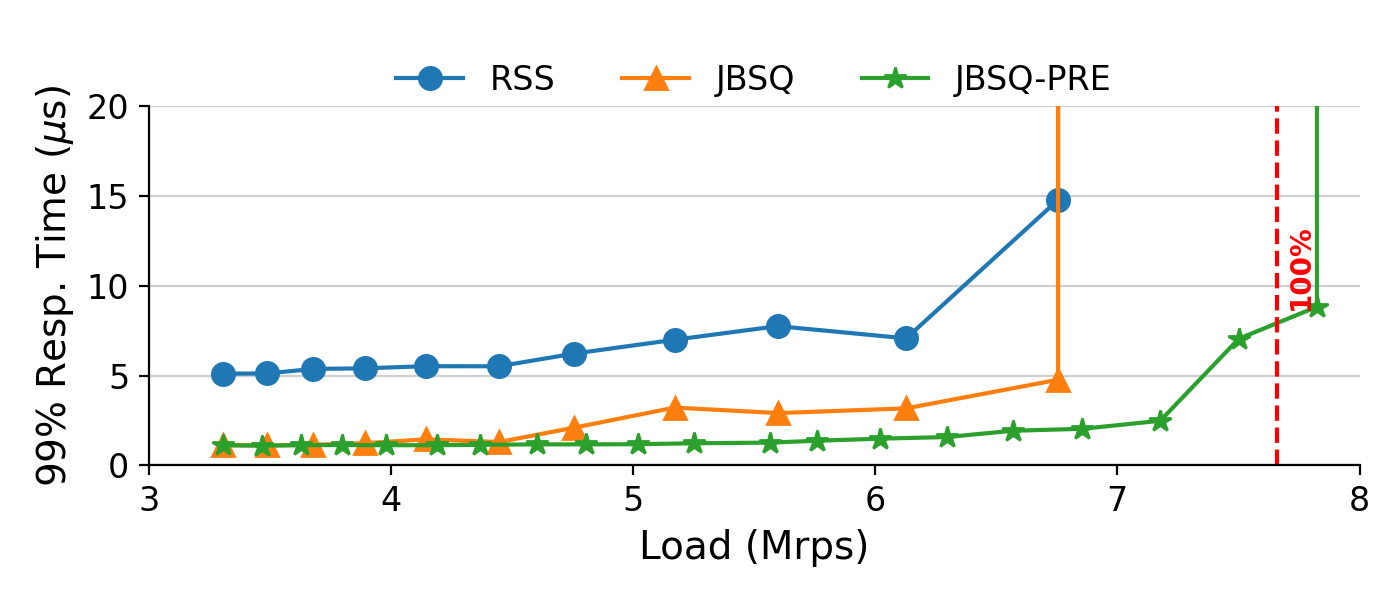

In [37]:
plt.figure(figsize=(7, 3))
ax = plt.gca()
rss_tail.plot(ax=ax, marker='o', markersize=8, label='RSS')
jbsq_tail.plot(ax=ax, marker='^', markersize=8, label='JBSQ')
jbsq_pre_tail.plot(ax=ax, marker='*', markersize=8, label='JBSQ-PRE')
ax.axvline(7.66, linestyle='--', color='r')
ax.text(7.7, 11, '100%', color='r', rotation=90, va='center', weight="bold")
# plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (Mrps)')
plt.ylabel('99% Resp. Time ($\mu$s)')
ax.legend(loc='upper center', frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(alpha=0.6)
plt.ylim([0, 20])
plt.xlim([3, 8])
plt.tight_layout()
plt.show()